In [1]:
# EAD-U06.elaborazione-audio
folder = "EAD-U06.elaborazione-audio"

In [2]:
# GDRIVE
base_folder = "/content/drive/MyDrive/MyTeaching/Elaborazione-Audio-Digitale/EAD26_docente/"
from google.colab import drive
drive.mount('/content/drive')
# Change with your drive "media" folder
!ln -s "$base_folder/$folder/media" media
!ln -s "$base_folder/$folder/pyead" pyead
!echo "$base_folder/$folder/"

Mounted at /content/drive
/content/drive/MyDrive/MyTeaching/Elaborazione-Audio-Digitale/EAD26_docente//EAD-U06.elaborazione-audio/


In [3]:
"""
# GITHUB
base_url = "https://github.com/polito-EAD-2026/"
!git clone "{base_url}/EAD26-U05.analisi-audio-tempo-frequenza.git"
!mv "./{folder}/*" .
"""

Cloning into 'EAD26-U05.analisi-audio-tempo-frequenza'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 88 (delta 29), reused 6 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 15.60 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (29/29), done.
mv: cannot stat './EAD26-U06.elaborazione-audio/*': No such file or directory


In [3]:
# deps install
!pip install -q librosa
!pip install praat-parselmouth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 34.9 MB/s eta 0:00:00


In [5]:
# imports
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd


from pyead.plot_vs_time import plot_vs_time
from pyead.plot_vs_freq import plot_vs_freq
# from pyead.dft import dft

plt.rcParams['font.size'] = 16

In [6]:
import numpy as np

def dft(x, Fs, N=None):
  L = len(x)
  N = L if N is None else N
  X = np.fft.rfft(x, N)
  X_ = np.abs(X) / (L/2)
  freq = np.fft.rfftfreq(N, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  # X_dBFS = 20*np.log10(X_)
  return X_, freq


def normalize(x):
  return x / np.max(np.abs(x))

Loaded ./media/aa-my.wav 1.04s at 16000Hz


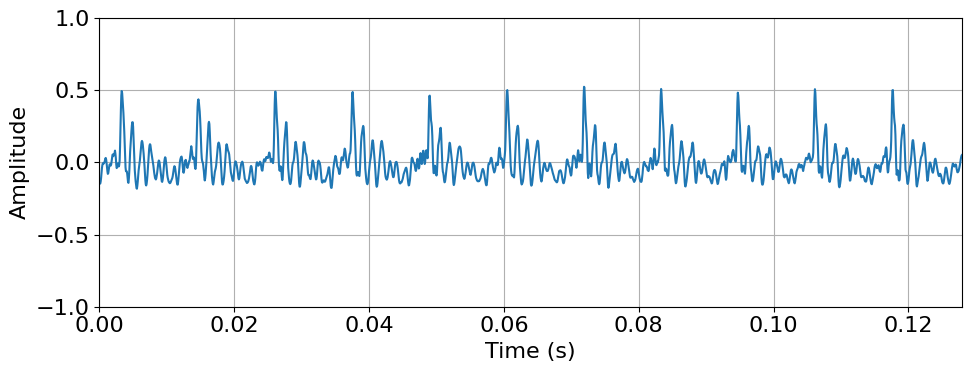

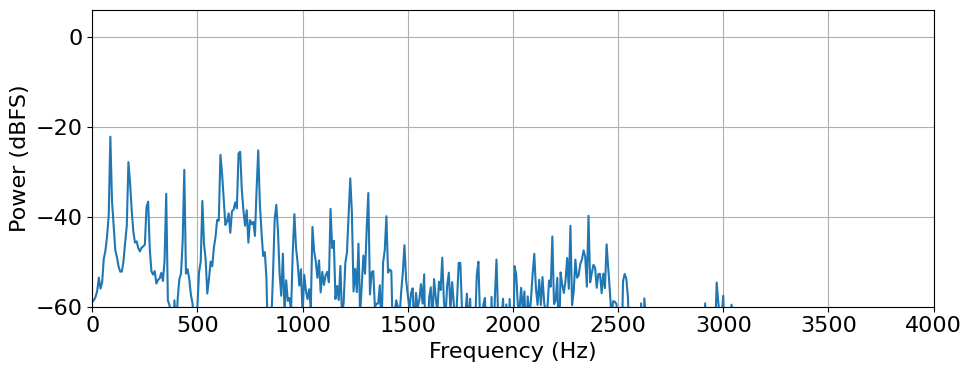

In [34]:
filename = './media/aa-my.wav'
y, sr = librosa.load(filename, sr=None)
print(f"Loaded {filename} {len(y)/sr:.2f}s at {sr}Hz")

# frame
L = 2048
idx = 1
frame = y[idx*L:(idx+1)*L]

fig, ax = plt.subplots(figsize=(10,4))
t = np.arange(0,len(frame))/sr
plot_vs_time(frame, t, fig=(fig,ax))
plt.show()

X, f = dft(frame, sr)
fig, ax = plt.subplots(figsize=(10,4))
plot_vs_freq(X, f, Fs=sr, type="log", fig=(fig,ax), xlim=[0,4000])

ipd.display(ipd.Audio(y, rate=sr))


In [26]:
# FROM SIGNAL TO CEPSTRUM

## input
# frame: audio frame

NFFT = 2048
# frame = preprocess_frame(frame)
win = np.hamming(len(frame))

spectrum = np.fft.fft(frame*win, NFFT)
log_spectrum = np.log(np.abs(spectrum) + 1e-10)  # Add small constant to avoid log(0)

# Compute cepstrum
cepstrum = np.fft.ifft(log_spectrum)



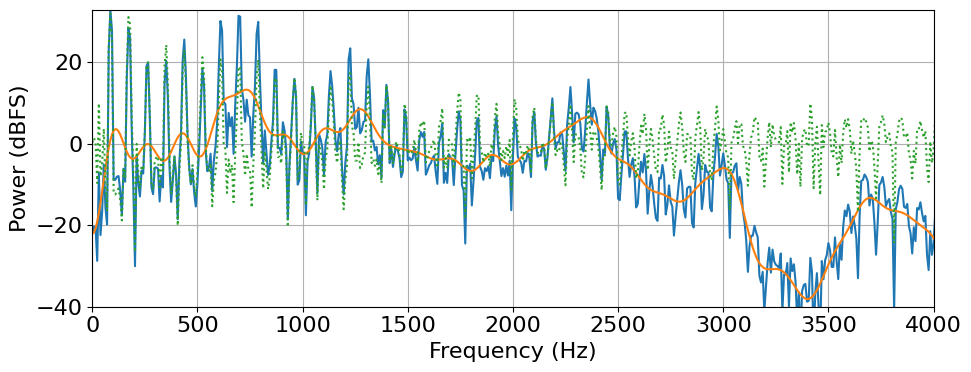

In [29]:
# FROM CEPSTRUM TO SPECTRUM ENVELOPE

## input
# cepstrum: cepstrum
# sr: sample rate

cutoff = 13

# Lifter the cepstrum (keep only first cutoff coefficients)
liftered_cepstrum = cepstrum.copy()
liftered_cepstrum[cutoff:NFFT-cutoff] = 0 # length is NFFT (two side spectrum)

# Convert back to spectrum
vocal_tract_spectrum = np.exp(np.real(np.fft.fft(liftered_cepstrum)))

# Get original spectrum magnitude
full_spectrum = np.abs(spectrum)
# Prepare frequency axis
frequencies = np.fft.fftfreq(NFFT, d=1./sr)

# Lifter the cepstrum (keep only last cutoff coefficients)
liftered_cepstrum = cepstrum.copy()
liftered_cepstrum[0:cutoff] = 0 # length is NFFT (two side spectrum)
liftered_cepstrum[NFFT-cutoff:NFFT] = 0 # length is NFFT (two side spectrum)

# Convert back to spectrum
source_spectrum = np.exp(np.real(np.fft.fft(liftered_cepstrum)))

# Truncate to Nyquist Freq
full_spectrum = full_spectrum[:NFFT//2]
vocal_tract_spectrum = vocal_tract_spectrum[:NFFT//2]
source_spectrum = source_spectrum[:NFFT//2]
frequencies = frequencies[:NFFT//2]

fig, ax = plt.subplots(figsize=(10,4))
ymax, ymin = 20*np.log10(np.max(full_spectrum)), -40
plot_vs_freq(full_spectrum, frequencies, Fs=sr, type="log", fig=(fig,ax), ylim=[ymin,ymax], xlim=[0,4000])
plot_vs_freq(vocal_tract_spectrum, frequencies, Fs=sr, type="log", fig=(fig,ax), ylim=[ymin,ymax], xlim=[0,4000])
plot_vs_freq(source_spectrum, frequencies, Fs=sr, type="log", fig=(fig,ax), ylim=[ymin,ymax], xlim=[0,4000], fmt=':')


183 0.0114375 87.43169398907104


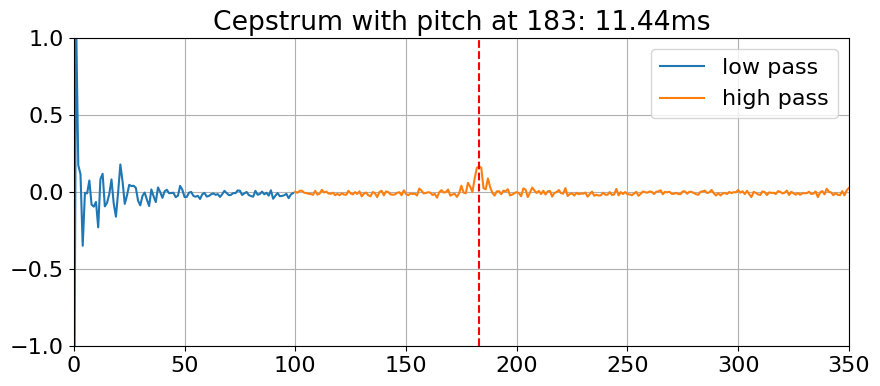

In [31]:
fmin, fmax = 50, 500
# Range di quefrency da cercare per la voce parlata
qmin = int(sr / fmax)    # es. 44100/400 ≈ 110 campioni
qmax = int(sr / fmin)    # es. 44100/60  ≈ 735 campioni

# Trova massimo nel range vocale
qcand = np.argmax(cepstrum[qmin:qmax]) + qmin

# Conversione quefrency → frequenza
T0 = qcand / sr
f0 = 1.0 / T0

print(qcand, T0, f0)

rcepstrum = np.real(cepstrum[:NFFT//2])
fig, ax = plt.subplots(figsize=(10,4))
n = np.arange(0,len(rcepstrum))
ax.plot(n[:cutoff], rcepstrum[:cutoff], label="low pass")
ax.plot(n[cutoff:], rcepstrum[cutoff:], label="high pass")
ax.grid(True)
ax.set_xlim(0,350)
ax.set_ylim(-1,1)
ax.vlines(qcand, ymin=-1, ymax=1, linestyles="dashed", colors="red")
ax.set_title(f"Cepstrum with pitch at {qcand}: {T0*1000:.2f}ms")
plt.legend()

Pitch: F0: 86 Hz,
Formants: F1: 680 Hz, F2: 1326 Hz, F3: 2424 Hz


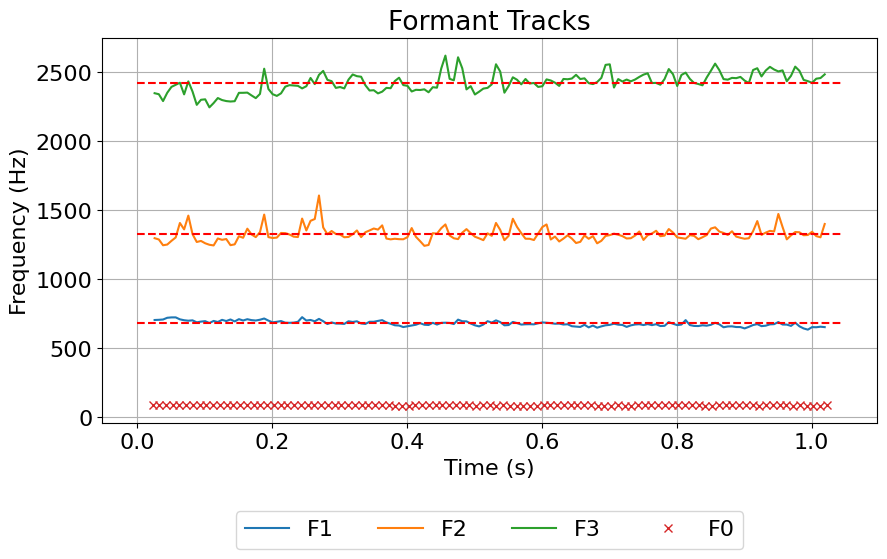

[705.5499000814209, 706.9431577157836, 709.152738617312, 721.6990134343506, 724.4207864348672, 724.5447882297955, 710.414072060666, 703.7886083195626, 700.4036017026341, 703.063691892919, 688.6484023047791, 693.9729452066382, 697.2481683772623, 683.5503783428575, 698.8781142196397, 691.0250414533591, 706.7226574390431, 698.0097429483233, 709.4043934472982, 695.1023579139666, 711.622849706395, 702.0843262942458, 711.2348971374955, 704.5986438154144, 701.854074821126, 707.5841520587849, 716.3607985385981, 701.1649539103212, 688.5541969017088, 692.5638891605721, 697.8318797623388, 686.0515704781961, 685.125721371372, 686.6168048196499, 692.5023296669324, 726.0576340111406, 701.6400698583291, 705.7903751957915, 696.1149314839524, 713.5925888847528, 696.7850209402324, 676.3700518444283, 688.0434171843866, 679.8987031407194, 679.6470849403815, 677.1671604449404, 696.330302665634, 691.4346400087039, 696.2644960971695, 680.3317373042258, 676.9641102567122, 692.7782147394084, 692.7332077313483,

In [37]:
import parselmouth
filename = './media/aa-my.wav'

# Sound object from file
snd = parselmouth.Sound(filename)
xt = snd.xs()      # time axis
x = snd.values[0]  # snd.values is an array, get [0] track

# Pitch object
pitch = snd.to_pitch()
# Get pitch values as a NumPy array
pitch_values = pitch.selected_array['frequency']

# Formant object
formants = snd.to_formant_burg()
formant_times = formants.ts()
formant_values = [
    [formants.get_value_at_time(1, t),
    formants.get_value_at_time(2, t),
    formants.get_value_at_time(3, t)]
    for t in formant_times
]

formant_values = np.array(formant_values)


# Plot the formant tracks

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(formants.ts(), formant_values[:, 0], label="F1")
plt.plot(formants.ts(), formant_values[:, 1], label="F2")
plt.plot(formants.ts(), formant_values[:, 2], label="F3")
plt.plot(pitch.ts(), pitch_values, 'x', label="F0")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Formant Tracks")
# plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.legend(bbox_to_anchor=(0.5, -0.20), loc='upper center', ncol=4)
plt.grid(True)

F0_mean = np.mean(pitch_values)
print(f"Pitch: F0: {int(F0_mean)} Hz,")

F1_mean = np.mean(formant_values[:, 0])
F2_mean = np.mean(formant_values[:, 1])
F3_mean = np.mean(formant_values[:, 2])
print(f"Formants: F1: {int(F1_mean)} Hz, F2: {int(F2_mean)} Hz, F3: {int(F3_mean)} Hz")

plt.hlines([F1_mean, F2_mean, F3_mean], xmin=0, xmax=xt[-1], linestyles="dashed", colors="red")
plt.show()

F1_values = [formants.get_value_at_time(1, t)
  for t in formant_times]
print(F1_values)

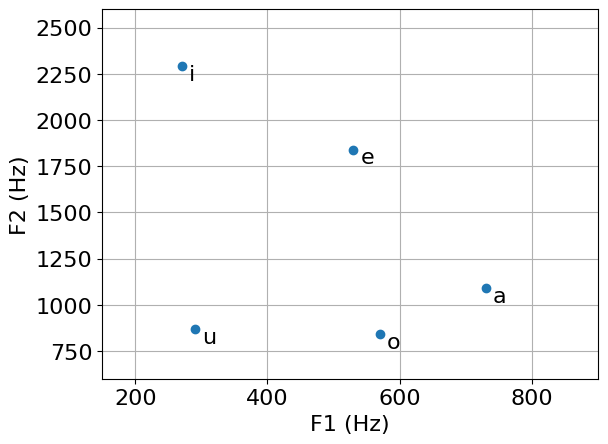

In [16]:
# MINIMAL GENERATE VOWEL
import numpy as np
from scipy import signal

vowel_formants = {
    'a': [730, 1090, 2440],
    'e': [530, 1840, 2480],
    'i': [270, 2290, 3010],
    'o': [570, 840, 2410],
    'u': [290, 870, 2240]
}

plt.scatter([ k[0] for k in vowel_formants.values() ], [ k[1] for k in vowel_formants.values() ])
plt.xlim([150,900])
plt.ylim([600,2600])
for k in vowel_formants.keys():
    plt.annotate(f"{k}", (vowel_formants[k][0], vowel_formants[k][1]), xytext=(5, -10), textcoords='offset points')
plt.xlabel('F1 (Hz)')
plt.ylabel('F2 (Hz)')
plt.grid()
plt.show()



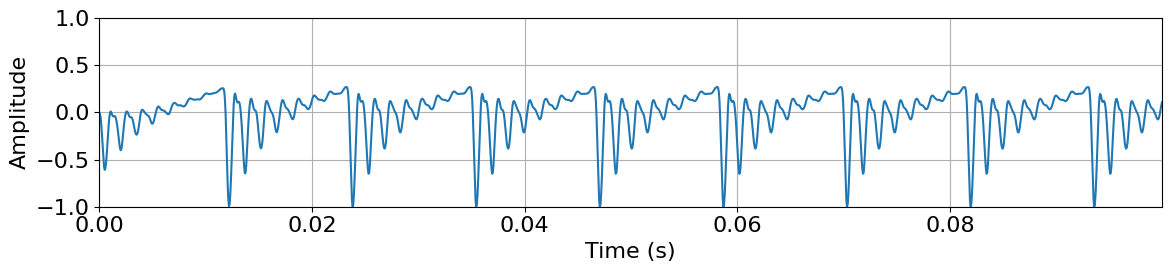

In [19]:
def create_formant_filter(formants, sample_rate, bandwidth=50):
    """
    Create filter coefficients based on formant frequencies
    formants: list of formant frequencies [F1, F2, F3]
    bandwidth: bandwidth for each formant in Hz
    """
    order = 12  # Filter order
    nyquist = sample_rate / 2

    # Create poles for each formant
    poles = []
    for formant in formants:
        if formant < nyquist:
            r = np.exp(-np.pi * bandwidth / nyquist)
            theta = 2 * np.pi * formant / sample_rate
            poles.extend([r * np.exp(1j * theta), r * np.exp(-1j * theta)])

    # Create filter from poles
    a = np.poly(poles)
    b = [1.0]  # All-pole filter

    return b, a

sr = 16000
f0 = 86
f0 = f0
dur = 2

# Generate source signal
t = np.arange(int(sr * dur)) / sr
source = signal.sawtooth(2 * np.pi * f0 * t)

# Create and apply formant filter
"""
vowel = 'e'
formants = vowel_formants[vowel]
"""
formants = [F1_mean, F2_mean, F3_mean]

b, a = create_formant_filter(formants, sr)
output = normalize(signal.lfilter(b, a, source))

ipd.display(ipd.Audio(output, rate=sr))

output_ = output[0:sr//10]
plot_vs_time(normalize(output_), np.arange(len(output_))/sr)

import soundfile as sf
sf.write(f"vowel_{vowel}.wav", output, sr)


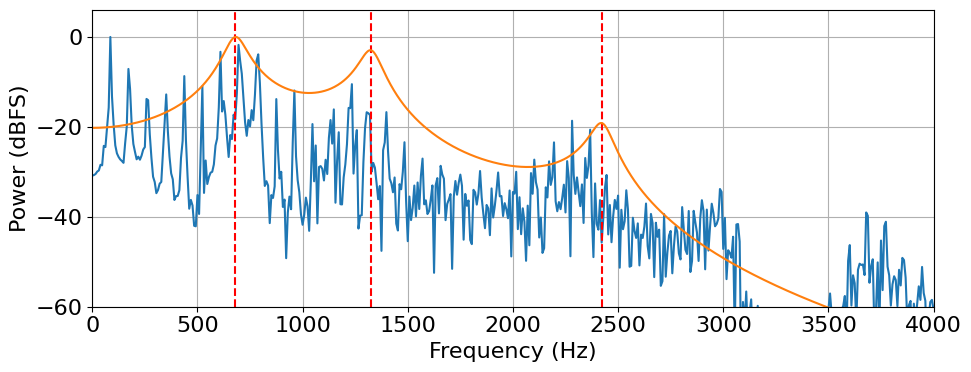

In [48]:
def normalize_db(x):
  return x + np.max(x)*-1

X, f = dft(x, sr, N=2048)
fig, ax = plt.subplots(figsize=(10,4))
# X = X*64 # adapt gain
plot_vs_freq(normalize(X), f, Fs=sr, type="log", fig=(fig,ax), xlim=[0,4000])

ax.vlines([F1_mean, F2_mean, F3_mean], ymin=-60, ymax=10, linestyles="dashed", colors="red")

import scipy
w, H = scipy.signal.freqz(b, a, worN=2048)
# modulo in dB
H_dB = 20 * np.log10(np.abs(H) + 1e-12)
f_hz = w/np.pi*(sr/2)
ax.plot(f_hz, normalize_db(H_dB))

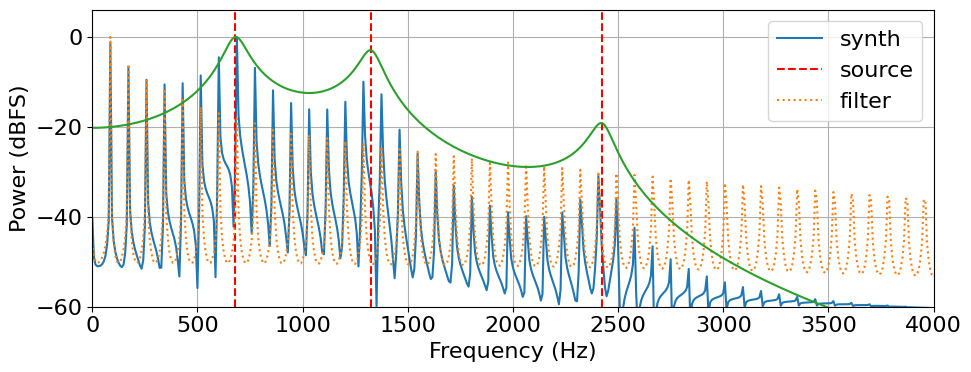

In [52]:
def normalize_db(x):
  return x + np.max(x)*-1

X, f = dft(output, sr, N=2048)
fig, ax = plt.subplots(figsize=(10,4))
# X = X*64 # adapt gain
plot_vs_freq(normalize(X), f, Fs=sr, type="log", fig=(fig,ax), xlim=[0,4000])

ax.vlines([F1_mean, F2_mean, F3_mean], ymin=-60, ymax=10, linestyles="dashed", colors="red")

S, f = dft(source, sr, N=2048)
S = normalize(S)
ax.plot(f, 20*np.log10(S), ':')


import scipy
w, H = scipy.signal.freqz(b, a, worN=2048)
# modulo in dB
H_dB = 20 * np.log10(np.abs(H) + 1e-12)
f_hz = w/np.pi*(sr/2)
ax.plot(f_hz, normalize_db(H_dB))

plt.legend(['synth', 'source', 'filter'])

/usr/local/lib/python3.12/dist-packages/IPython/lib/display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


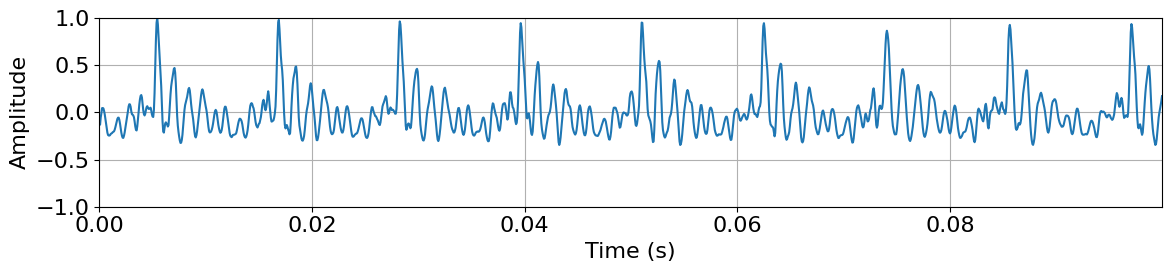

In [14]:
# Ricostruzione di un filtro FIR tramite trasformata inverse
# Qui assumiamo fase minima (scelta comune in letteratura)
h = np.fft.ifft(np.log(vocal_tract_spectrum) + 0j)
y_ = np.convolve(source, h, mode="same")
ipd.display(ipd.Audio(y_, rate=sr))

y_ = y[0:sr//10]
plot_vs_time(normalize(y_), np.arange(len(y_))/sr)